In [1185]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import math
from datetime import datetime
import matplotlib.pyplot as plt

In [1186]:
# Dashboard
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 30)
pd.options.display.max_seq_items = 300
#pd.options.display.max_rows = 4000
sns.set(style="white")
review_rate=0.5    # Assumed share of bookings that were followed up by a user review

In [1187]:
# Import data_clean
data = pd.read_pickle("saves/data_clean.pkl")

In [1188]:
# Import reviews.csv and convert date to datetime
data_rev = pd.read_csv("data/2020-02-18/reviews.csv")
data_rev.date = data_rev.date.astype('datetime64[D]')
print(data_rev.shape)
data_rev.head(3)

(543302, 2)


,listing_id,date
0,3176,2009-06-20
1,3176,2010-11-07
2,3176,2010-11-24


In [1191]:
# Create time series dataframe with prices for the time period 04/2018-03/2020 (2 years)

# Save "price" column of data (01/2020) as "data_ts"
data_ts = pd.DataFrame(data.price.copy())

# Rename "price" column to reflect the date "2020-01"
data_ts.rename(columns={"price": "2020-01"}, inplace=True)

# Import other files from 2 year period and add price column (renamed to reflect the date) to "data_ts"
all_files = glob.glob(os.path.join("data/timeseries", "*.csv.gz"))         # save paths of files as list
for f in all_files:                                                        # loop through all paths
    df_temp = pd.read_csv(f, sep=',')                                      # import each file from path and save as temporary dataframe
    df_temp.drop(df_temp.columns.difference(['id','price']), 1, inplace=True)        # keep only columns 'id' and 'price' in temporary dataframe
    df_temp.price = [float(i.strip("$").replace(",","")) for i in df_temp.price]        # convert 'price' into float
    data_ts = pd.merge(data_ts, df_temp, how="left", left_on='id', right_on='id')        # add 'price' from temporary dataframe onto full 'data_ts'
    f_date = f.split('/')[-1].split('_')[0]                                # temporarily save date from file path
    data_ts.rename(columns={"price": f_date}, inplace=True)                # change new 'price' column to reflect the date
    
# Set id as index again and sort columns (newest date to left)
data_ts.set_index('id', inplace=True)
data_ts = data_ts.reindex(sorted(data_ts.columns, reverse=True), axis=1)

# Print new dataframe and its shape
print(data_ts.shape)
data_ts.head()

(23854, 24)


,2020-03,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,60.0,60.0,NaN,NaN,60.0,60.0,60.0,60.0,NaN,NaN,60.0,60.0,60.0,60.0,60.0,60.0,60.0,NaN,60.0,60.0,60.0,60.0
3176,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
3309,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,NaN,NaN,NaN,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
6883,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125.0,125.0,125.0,NaN,NaN,NaN
7071,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,34.0,42.0,42.0,42.0,42.0,47.0,47.0,47.0,47.0,47.0,40.0


In [1192]:
sum([True for idx,row in data_ts.iterrows() if any(row.isnull())])

13363

In [1194]:
data_ts.isnull().sum().sum()

157978

In [1197]:
data_ts_rel_mths = data_ts.iloc[:,:4]

In [1198]:
data_ts_rel_mths.head()

,2020-03,2020-02,2020-01,2019-12
id,,,,
2015,NaN,NaN,60.0,60.0
3176,90.0,90.0,90.0,90.0
3309,28.0,28.0,28.0,28.0
6883,125.0,125.0,125.0,125.0
7071,33.0,33.0,33.0,33.0


In [1199]:
sum([True for idx,row in data_ts_rel_mths.iterrows() if any(row.isnull())])

3271

# Feature Engineering

## Occupancy

Calculation of **occupancy rate** is inspired by the **San Francisco model**, which is also applied by [Inside AirBnB](http://insideairbnb.com/about.html):

- (**A**) Determine the **average length of stay for Berlin**
- (**B**) Calculate **reviews relevant for considered timeframe (Feb 1-29 2020)**
- (**C**) Determine **active months in timeframe** from price (not relevant if only 1 month)
- (**D**) Estimate **# of bookings in considered timeframe (End Jan-end Feb 2020)** using (**B**)
- (**E**) **Occupancy rate** = (**D**)x(**A**) / ((**C**)/months x 365)

Read more about the core idea behind the calculations of the model [here](https://sfbos.org/sites/default/files/FileCenter/Documents/52601-BLA.ShortTermRentals.051315.pdf). Assumptions were adapted for the purpose of this analysis, mainly due to the core idea of considering only the two most recent years.

(**A**) Determine the **average length of stay for Berlin** (assumed 3 days in most cities)

For the purpose of this model, around **3 nights** are assumed as average length of stay in Berlin and used as basis for calculation, unless a higher minimum length is specified
- Back in 2016, [4.6](https://www.airbnbcitizen.com/wp-content/uploads/2016/04/airbnb-community-berlin-en.pdf) has been reported as the average length of stay
- Inside AirBnB uses 3 nights for cities where no current data is available, but uses [6.3 nights](http://insideairbnb.com/berlin/#) for its Berlin visualization

In [1190]:
# Add column to main dataframe for avg length of stay, being either a) 5 nights or b) minimum_nights if higher than 5 or c) avg of min and max if max is 5 or lower
avg_nights = []
for idx in data.index:
    if data.maximum_nights[idx] <=5:
        avg_nights.append((data.maximum_nights[idx]+data.minimum_nights[idx])/2)
    elif data.minimum_nights[idx] >3:
        avg_nights.append(data.minimum_nights[idx])
    else:
        avg_nights.append(3)
data["avg_nights"] = avg_nights

(**B**) Calculate **reviews in last two years**

In [1137]:
# Create target dataframe
data_rev_count = data_rev[(data_rev.date > "2020-01-31") & (data_rev.date < "2020-03-01")]                          # Remove all reviews older than April 2018
data_rev_count = pd.DataFrame(data_rev_count.listing_id.value_counts())          # Count reviews per listing and save as table
data_rev_count.rename(columns={"listing_id": "reviews_feb20"}, inplace=True)     # Change column name
data = pd.merge(data, data_rev_count, how="left", left_index=True, right_index=True)    # Add column to main dataset
data.reviews_feb20.fillna(0, inplace=True)

(**C**) Determine **active months and relevant months** from price

In [1138]:
# Count the months where listings were online with a price (not relevant if 1 mth)
#data["active_months"] = data_ts.count(axis=1)
data["active_months"] = 1
relevant_mths = 1

(**D**) Estimate **# of bookings in last two years** by dividing (**B**) through a assumed 50% review rate (i.e. one review corresponds to two bookings)

In [1139]:
# Calculate bookings estimate and replace NaN with 0
data["bookings_est"] = data.reviews_feb20 / review_rate
data.bookings_est.fillna(0, inplace=True)

(**E**) **Occupancy rate** = (**D**)x(**A**) / ((**C**)/23 x 365)

In [1140]:
# Calculate occupancy rate
data["occupancy_rate"] = data.bookings_est * data.avg_nights / (data.active_months/relevant_mths*365)

In [1141]:
# Capping occupancy at 100%
occupancy_temp = []
for rate in data.occupancy_rate:
    if rate < 1:
        occupancy_temp.append(rate)
    else:
        occupancy_temp.append(1)
data.occupancy_rate = occupancy_temp

In [1142]:
# Split occupancy into 3 classes (TARGET)
occupancy_class = []
for rate in data.occupancy_rate:
    if rate < 0.25:
        occupancy_class.append(0)
    elif rate < 0.75:
        occupancy_class.append(1)
    else:
        occupancy_class.append(2)
data["occupancy_class"] = occupancy_class

## Seasonality

**Fill empty values in data_ts to calculate weighted avg price and seasonal weight (2 yrs from Apr'18 - Mar'20)**

In [1183]:
# Get a weighted average for monthly price

# Calculate monthly average for columns in 'data_ts' and save as list
mth_avg = []
for col in data_ts.columns:
    mth_avg.append(data_ts[col].median())

# Save weighted monthly average as dictionary
mth = ["02_Feb", "01_Jan", "12_Dec", "11_Nov", "10_Oct", "09_Sep", "08_Aug", "07_Jul", "06_Jun", "05_May", "04_Apr", "03_Mar"]


mth_avg_weight = {}
for i in range(11):
    mth_avg_weight.update({mth[i]:(mth_avg[i]*0.7+mth_avg[i+12]*0.3)})
mth_avg_weight.update({mth[11]:mth_avg[11]*0.95})
#print(mth_avg_weight)

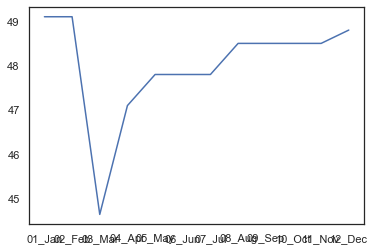

<Figure size 432x288 with 0 Axes>

In [1184]:
# Plot weighted average monthly price over year - IGNORE AS LOGICALLY REFLECTS MAR HIGHEST, APR LOWEST
lists = sorted(mth_avg_weight.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()
plt.tight_layout()

In [1145]:
# Fill empty cells with values from next period
data_ts_filled = data_ts.copy()
for i, col in enumerate(data_ts_filled.columns):
    if i > 0:
        data_ts_filled[col] = data_ts_filled[col].fillna(data_ts_filled[data_ts_filled.columns[i-1]])
data_ts_filled.head()

,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,
3176,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
3309,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
6883,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0
7071,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,34.0,42.0,42.0,42.0,42.0,47.0,47.0,47.0,47.0,47.0,40.0
9991,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0


In [1146]:
# Create column with calculated weighted average price
#weight = 0.4
#price_avg = []
#for 
data["price_avg"] = data_ts_filled.iloc[:,0]*0.5 + data_ts_filled.iloc[:,7]*0.25 + data_ts_filled.iloc[:,15]*0.15 + data_ts_filled.iloc[:,22]*0.10 

In [1147]:
# Create column with calculated price difference between current price and weighted average price
data["price_diff"] = data.price - data.price_avg

In [1148]:
# Create column with calculated price difference as percentage
data["price_diff_perc"] = data.price_diff / data.price

In [1149]:
# Output individual listings from data for review
#data[data.index==42343281]

In [1150]:
# Output individual listings from data_ts for review
data_ts[data_ts.index==36609709]

,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,
36609709,350.0,72.0,77.0,77.0,77.0,77.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1151]:
# Output individual listings from data_ts_filled for review
data_ts_filled[data_ts_filled.index==36609709]

,2020-02,2020-01,2019-12,2019-11,2019-10,2019-09,2019-08,2019-07,2019-06,2019-05,2019-04,2019-03,2019-02,2019-01,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04
id,,,,,,,,,,,,,,,,,,,,,,,
36609709,350.0,72.0,77.0,77.0,77.0,77.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [1152]:
# Check highest price vs avg differences
data[data.price_diff_perc>0.33].head()

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,instant_bookable,interaction,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,name,neighborhood_overview,neighbourhood,notes,price,property_type,review_scores_rating,room_type,security_deposit,space,summary,transit,weekly_price,zipcode,avg_nights,reviews_lt2yr,active_months_lt2yr,bookings_est,occupancy_rate,occupancy_class,price_avg,price_diff,price_diff_perc
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
593920,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"{Internet,Wifi,Kitchen,""Free parking on premis...",0,1.0,1.0,2.0,1,strict_14_with_grace_period,5.0,"A cosy, artsy apartment, centrally located, fo...",0.0,1,f,f,No smoking please and try to water my plants.,f,"I am good with email contact, as I am often ab...",t,52.49517,13.40122,1125,1,700.0,"1,5 rooms in wonderful Kreuzberg","My neighborhood in Kreuzberg is the ""Bergmannk...",Kreuzberg,The house is on the quiet side and the neighbo...,179.0,Apartment,100.0,Entire home/apt,0.0,"A little jewel of an apartment, open kitchen/l...","A cosy, artsy apartment, centrally located, fo...","- M41 bus stop right in front of the door, str...",230.0,zip_10961,3.0,0.0,23,0.0,0.000000,0,107.0,72.0,0.402235
1564806,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",77,1.5,1.0,1.0,49,strict_14_with_grace_period,0.0,"with 12-man communal shared bathroom, TV, WIFI...",23.0,1,f,f,- check out before 10:00 am. - no smoking in t...,f,There is always at least 1 member of staff on ...,t,52.51614,13.42485,14,1,0.0,"6-Bed mixed dorm ,Shared Bathroom 3",Welcome Traveler. The Singer Hostel and Apart...,Mitte,Since 01.01.2014 the city of Berlin had to ado...,150.0,Hostel,91.0,Shared room,0.0,The Singer 109 Hostel is located in the heart ...,"with 12-man communal shared bathroom, TV, WIFI...",U-Bahn / Underground /Subway / Metro: U5 (Stra...,0.0,zip_10179,3.0,66.0,23,132.0,0.800000,5,85.0,65.0,0.433333
1564917,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",85,1.5,1.0,1.0,49,strict_14_with_grace_period,0.0,"with bathroom, TV, WIFI, bed linen, and storag...",29.0,1,f,f,- Check out before 10:00 a.m. - No smoking in ...,f,There is always at least 1 member of staff on ...,t,52.51767,13.42518,14,1,0.0,"4-Bedroom mixed, Ensuite , TV No. 1",Welcome Traveler. The Singer Hostel and Apart...,Mitte,Since 01.01.2014 the city of Berlin had to ado...,99.0,Hostel,93.0,Shared room,0.0,The Singer 109 Hostel is located in the heart ...,"with bathroom, TV, WIFI, bed linen, and storag...",U-Bahn / Underground /Subway / Metro: U5 (Stra...,0.0,zip_10179,3.0,92.0,23,184.0,0.800000,5,66.0,33.0,0.333333
1565012,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",86,1.5,1.0,1.0,49,strict_14_with_grace_period,0.0,"with en-suite bathroom, TV, WIFI, bed linen, a...",27.0,1,f,f,- check out before 10:00 am. - no smoking in t...,f,There is always at least 1 member of staff on ...,t,52.51756,13.42441,14,1,0.0,"6-Bedroom mixed, Ensuite , TV No. 1",Welcome Traveler. The Singer Hostel and Apart...,Mitte,Since 01.01.2014 the city of Berlin had to ado...,150.0,Hostel,93.0,Shared room,0.0,The Singer 109 Hostel is located in the heart ...,"with en-suite bathroom, TV, WIFI, bed linen, a...",U-Bahn / Underground /Subway / Metro: U5 (Stra...,0.0,zip_10179,3.0,55.0,23,110.0,0.800000,5,87.5,62.5,0.416667
1565047,8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"{TV,Inter

## Other Features

**Change column content**

In [1153]:
# Reduce cancellation_policy to 4 classes
data.cancellation_policy.replace(["strict_14_with_grace_period", "super_strict_60", "super_strict_30"], ["strict", "super_strict", "super_strict"], inplace=True)

In [1154]:
# Reduce property_type to 6 classes, as per Airbnb classification (see listing creation in pdf)
data.property_type.replace(["Condominium", "Loft", "Vacation home"], "Apartment", inplace=True)
data.property_type.replace(["Aparthotel", "Hostel", "Hotel", "Resort", "Serviced apartment"], "Boutique hotel", inplace=True)
data.property_type.replace(["Casa particular (Cuba)", "Farm stay", "Nature lodge", "Pension (South Korea)"], "Bed and breakfast", inplace=True)
data.property_type.replace(["Bungalow", "Cabin", "Chalet", "Cottage", "Dome house", "Earth house", "Houseboat", "Hut", "Lighthouse", "Tiny house", "Townhouse", "Villa"], "House", inplace=True)
data.property_type.replace(["Guesthouse", "Guest suite"], "Secondary unit", inplace=True)
data.property_type.replace(["Barn", "Boat", "Bus", "Camper/RV", "Campsite", "Castle", "Cave", "Igloo", "Island", "Plane", "Tent", "Tipi", "Train", "Treehouse", "Windmill", "Yurt"], "Unique space", inplace=True)


In [1155]:
# Drop all listings that are not in the above 6 classes
data = data[data.property_type.isin(["Apartment", "Boutique hotel", "Bed and breakfast", "House", "Secondary unit", "Unique space"])]

In [1156]:
# Fill all columns with "0" of "monthly_price" and "weekly_price" with 7x/30x "price"
data["monthly_price"] = np.where(data.monthly_price==0, data.price*30, data.monthly_price)
data["weekly_price"] = np.where(data.weekly_price==0, data.price*7, data.weekly_price)


**Convert binary features to 1/0**

In [1157]:
# Convert t/f to 1/0 for various features
data.host_is_superhost.replace(["t", "f"], [1, 0], inplace=True)
data.host_identity_verified.replace(["t", "f"], [1, 0], inplace=True)
data.is_location_exact.replace(["t", "f"], [1, 0], inplace=True)
data.instant_bookable.replace(["t", "f"], [1, 0], inplace=True)

In [1158]:
# Change availability_365 to 1/0
data.availability_365 = np.where(data.availability_365!=0, 1, 0)

In [1159]:
# Create 1/0 for text descriptions
#data["description_exist"] = [0 for i in range(len(data.index))]
data["description_exist"] = np.where(data.description!="", 1, 0)
data["house_rules_exist"] = np.where(data.house_rules!="", 1, 0)
data["interaction_exist"] = np.where(data.interaction!="", 1, 0)
data["neighborhood_overview_exist"] = np.where(data.neighborhood_overview!="", 1, 0)
data["notes_exist"] = np.where(data.notes!="", 1, 0)
data["space_exist"] = np.where(data.space!="", 1, 0)
data["summary_exist"] = np.where(data.summary!="", 1, 0)
data["transit_exist"] = np.where(data.transit!="", 1, 0)

**Create numerical features**

In [1160]:
# Calculate "price_calc" for one person from "price", "guests_included", "extra_people" and remove listings where "price_calc" ends up being <= 5
data["price_calc"] = data.price - 0.5*data.extra_people*(data.guests_included-1)
data = data[data.price_calc > 5]

In [1161]:
# Calculate "price_extra_people" (price) for additional persons from "price", "guests_included", "extra_people" and "accommodates"
data["price_extra_people"] = (data.extra_people*(data.accommodates-data.guests_included)+(0.5*data.extra_people*(data.guests_included-1)))/(data.accommodates-1)
data.price_extra_people.fillna(0, inplace=True)

In [1162]:
# Calculate existance of "price_extra_fees" from "security_deposit" and "cleaning_fee"
data["price_extra_fees"] = 0 + data.security_deposit + data.cleaning_fee

In [1163]:
# Calculate "descr_detail" as measure for how well the listing is described
data["descr_detail"] = 0 + data.description_exist + data.house_rules_exist + data.interaction_exist + data.neighborhood_overview_exist + data.notes_exist + data.space_exist + data.summary_exist + data.transit_exist

In [1164]:
# Calculate "accommodates_per_room" as feature to de-correlate "accommodates" and "bedrooms"
data["accommodates_per_room"] = data.accommodates/data.bedrooms

In [1165]:
# Calculate "accommodates_per_bed" as feature to de-correlate "accommodates" and "beds" and "bedrooms"
data["accommodates_per_bed"] = data.accommodates/data.beds

In [1166]:
# Calculate "wk_mth_discount" from "monthly_price" and "weekly_price" with "price"
data["wk_mth_discount"] = ((data.price*30-data.monthly_price)/(data.price*30) + (data.price*7-data.weekly_price)/(data.price*7)) / 2

**Create categorical features**

In [1167]:
# Categorize listings by "state" (basic, moderate, luxurious)

In [1168]:
# Modify text-based columns by counting words (.split().count)
data["description_len"] = [len(i.split()) for i in data.description]
data["house_rules_len"] = [len(i.split()) for i in data.house_rules]
data["interaction_len"] = [len(i.split()) for i in data.interaction]
data["neighborhood_overview_len"] = [len(i.split()) for i in data.neighborhood_overview]
data["notes_len"] = [len(i.split()) for i in data.notes]
data["space_len"] = [len(i.split()) for i in data.space]
data["summary_len"] = [len(i.split()) for i in data.summary]
data["transit_len"] = [len(i.split()) for i in data.transit]
data["text_len"] = (data.description_len/data.description_len.max() + data.house_rules_len/data.house_rules_len.max() +
                    data.interaction_len/data.interaction_len.max() + data.neighborhood_overview_len/data.neighborhood_overview_len.max() +
                    data.notes_len/data.notes_len.max() + data.space_len/data.space_len.max() + data.summary_len/data.summary_len.max() +
                    data.transit_len/data.transit_len.max()) / 8
data.text_len = data.text_len/data.text_len.max()

**Convert text columns into meaningful information**

In [1169]:
data.description.sample(5)

id
22376273    Centrally located large bedroom in Berlin-Moab...
40342585    Our cozy apartment is perfectly located betwee...
20784798    Super bright and huge apartment located right ...
9133614     This beautiful 2Room apartment with design fur...
24876567    Everything you need for a romantic getaway for...
Name: description, dtype: object

**Create log/sqrt from existing features**

Now we will replace certain features, which have relatively high skew (see 2_Clean), with their log

In [1170]:
# Create log "bathrooms_log" for numerical feature "bathrooms"
data["bathrooms_log"] = [math.log(el) for el in data["bathrooms"]]

In [1171]:
# Create sqrt "minimum_nights_sqrt" for numerical feature "minimum_nights"
data["minimum_nights_log"] = [math.sqrt(el) for el in data["minimum_nights"]]

In [1172]:
# Create log "price_extra_fees_sqrt" for numerical feature "price_extra_fees"
data["price_extra_fees_sqrt"] = [math.sqrt(el) for el in data["price_extra_fees"]]

In [1173]:
# Create log "price_log" for numerical feature "price_calc"
data["price_log"] = [math.log(el) for el in data["price_calc"]]

In [1174]:
# Create sqrt "review_scores_rating_sqrt" for numerical feature "review_scores_rating"
review_max = data.review_scores_rating.max()
data["review_scores_rating_sqrt"] = [math.sqrt(review_max-el) for el in data.review_scores_rating]
review_log_max = data.review_scores_rating_sqrt.max()
data["review_scores_rating_sqrt"] = [(review_log_max-el) for el in data.review_scores_rating_sqrt]
#data["review_scores_rating_sqrt"].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');

In [1175]:
# Create log "text_len_sqrt" for numerical feature "text_len"
data["text_len_sqrt"] = [math.sqrt(el) for el in data["text_len"]]

**Final check and cleaning before export**

In [1176]:
# Drop further columns
data.drop(["accommodates", "active_months_lt2yr", "amenities", "am_coffee_machine",
           "am_cooking_basics", "am_parking", "availability_365",
           "avg_nights", "bathrooms", "beds", "bookings_est", 
           "cleaning_fee", "descr_detail", "description", "description_exist", "description_len",
           "description_exist", "extra_people", "guests_included", "host_identity_verified",
           "house_rules", "house_rules_exist", "house_rules_len", "interaction", "interaction_exist", 
           "interaction_len", "is_location_exact", "minimum_nights",
           "monthly_price", "name", "neighborhood_overview", "neighborhood_overview_exist", 
           "neighborhood_overview_len", "notes", "notes_exist", "notes_len", "occupancy_rate",
           "price", "price_avg", "price_calc", "price_diff", "price_diff_perc", "price_extra_fees", 
           "review_scores_rating", "reviews_lt2yr", "security_deposit", 
           "space", "space_exist", "space_len", "summary", "summary_exist", "summary_len", "text_len",
           "transit", "transit_exist", "transit_len", "weekly_price"], inplace=True, axis=1)

| **DROPPED FEATURE** | **REASONING** |
| :----- | :----- |
| **am_coffee_machine** | high correlation (>0.3) with >5 other features |
| **am_parking** | high correlation (>0.3) with >5 other features |
| **availability_365** | high correlation (>0.3) with >5 other features |
| **descr_detail** | dropped in favour of **text_len** |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |
| **** |  |


In [1177]:
# Review datatypes (data.info()) (post-engineering)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23623 entries, 3176 to 42361801
Data columns (total 34 columns):
am_balcony                        23623 non-null float64
am_breakfast                      23623 non-null float64
am_child_friendly                 23623 non-null float64
am_elevator                       23623 non-null float64
am_essentials                     23623 non-null float64
am_nature_and_views               23623 non-null float64
am_pets_allowed                   23623 non-null float64
am_private_entrance               23623 non-null float64
am_smoking_allowed                23623 non-null float64
am_tv                             23623 non-null float64
am_white_goods                    23623 non-null float64
bedrooms                          23623 non-null float64
calculated_host_listings_count    23623 non-null int64
cancellation_policy               23623 non-null object
host_is_superhost                 23623 non-null int64
instant_bookable                  2

In [1178]:
# Sort columns in dataset
data = data.reindex(sorted(data.columns, reverse=False), axis=1)

In [1179]:
# Display engineered dataset
print(data.shape)
data.head(3)

(23623, 34)


,accommodates_per_bed,accommodates_per_room,am_balcony,am_breakfast,am_child_friendly,am_elevator,am_essentials,am_nature_and_views,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,bathrooms_log,bedrooms,calculated_host_listings_count,cancellation_policy,host_is_superhost,instant_bookable,latitude,longitude,maximum_nights,minimum_nights_log,neighbourhood,occupancy_class,price_extra_fees_sqrt,price_extra_people,price_log,property_type,review_scores_rating_sqrt,room_type,text_len_sqrt,wk_mth_discount,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,2.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,strict,0,0,52.53500,13.41758,1125,7.874008,Prenzlauer Berg,4,20.000000,16.666667,4.382027,Apartment,6.298521,Entire home/apt,0.772455,0.235450,zip_10405
3309,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1,strict,0,0,52.49885,13.34906,35,2.645751,Schöneberg,1,16.733201,0.000000,3.332205,Apartment,5.627647,Private room,0.863107,0.197024,zip_10777
6883,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1,moderate,0,0,52.51171,13.45477,90,1.732051,Friedrichshain,3,6.244998,0.000000,4.828314,Apartment,7.944272,Entire home/apt,0.630012,0.471181,zip_10243


**Export data_engineered**

In [1180]:
# Export dataset for further use in 4_Predictive Modeling
data.to_pickle("saves/data_engineered.pkl")

In [1181]:
# Alternative: Export with to_csv and save dtypes separately
#data.to_csv(r'saves/data_engineered.csv', index = True)
#data.dtypes.to_frame('types').to_csv('saves/types_engineered.csv')